In [2]:
import numpy as np

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier # brew install libomp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


In [129]:
from preprocess1 import process_SRNdata
shared = pd.read_table("../data/baxter.0.03.subsample.shared")
meta = pd.read_table("../data/metadata.tsv")

# Define x (features) and y (labels)
x, y = process_SRNdata(shared, meta)
print(x.columns)
# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

Index(['fit_result', 'Otu00001', 'Otu00002', 'Otu00003', 'Otu00004',
       'Otu00005', 'Otu00006', 'Otu00007', 'Otu00008', 'Otu00009',
       ...
       'Otu11258', 'Otu11263', 'Otu11269', 'Otu11270', 'Otu11271', 'Otu11274',
       'Otu11277', 'Otu11278', 'Otu11280', 'Otu11281'],
      dtype='object', length=6921)


/Users/kayadetunji/Documents/mBio_study_improv/codes/preprocess1.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data['Dx_Bin'].replace(diagnosis)


In [130]:
x=x.drop(['fit_result'], axis=1)

In [131]:
x.columns

Index(['Otu00001', 'Otu00002', 'Otu00003', 'Otu00004', 'Otu00005', 'Otu00006',
       'Otu00007', 'Otu00008', 'Otu00009', 'Otu00010',
       ...
       'Otu11258', 'Otu11263', 'Otu11269', 'Otu11270', 'Otu11271', 'Otu11274',
       'Otu11277', 'Otu11278', 'Otu11280', 'Otu11281'],
      dtype='object', length=6920)

In [88]:
# Initialize the models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the models
rf_model.fit(x_train, y_train)
xgb_model.fit(x_train, y_train)
lr_model.fit(x_train, y_train)
# Predictions
rf_pred = rf_model.predict(x_test)
xgb_pred = xgb_model.predict(x_test)
lr_pred = lr_model.predict(x_test)

# Calculate accuracy metrics
metrics = {
    'Model': ['Random Forest', 'XGBoost', 'Logistic Regression'],
    'Accuracy': [
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, xgb_pred),
        accuracy_score(y_test, lr_pred)
    ],
    'Precision': [
        precision_score(y_test, rf_pred),
        precision_score(y_test, xgb_pred),
        precision_score(y_test, lr_pred)
    ],
    'Recall': [
        recall_score(y_test, rf_pred),
        recall_score(y_test, xgb_pred),
        recall_score(y_test, lr_pred)
    ],
    'F1 Score': [
        f1_score(y_test, rf_pred),
        f1_score(y_test, xgb_pred),
        f1_score(y_test, lr_pred)
    ],
    'AUC': [
        roc_auc_score(y_test, rf_pred),
        roc_auc_score(y_test, xgb_pred),
        roc_auc_score(y_test, lr_pred)
    ]
}

metrics_df = pd.DataFrame(metrics)
metrics_df

/Users/kayadetunji/Documents/mBio_study_improv/new/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:26:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.721088,0.804348,0.536232,0.643478,0.710424
1,XGBoost,0.707483,0.724138,0.608696,0.661417,0.701784
2,Logistic Regression,0.639456,0.625000,0.579710,0.601504,0.636009


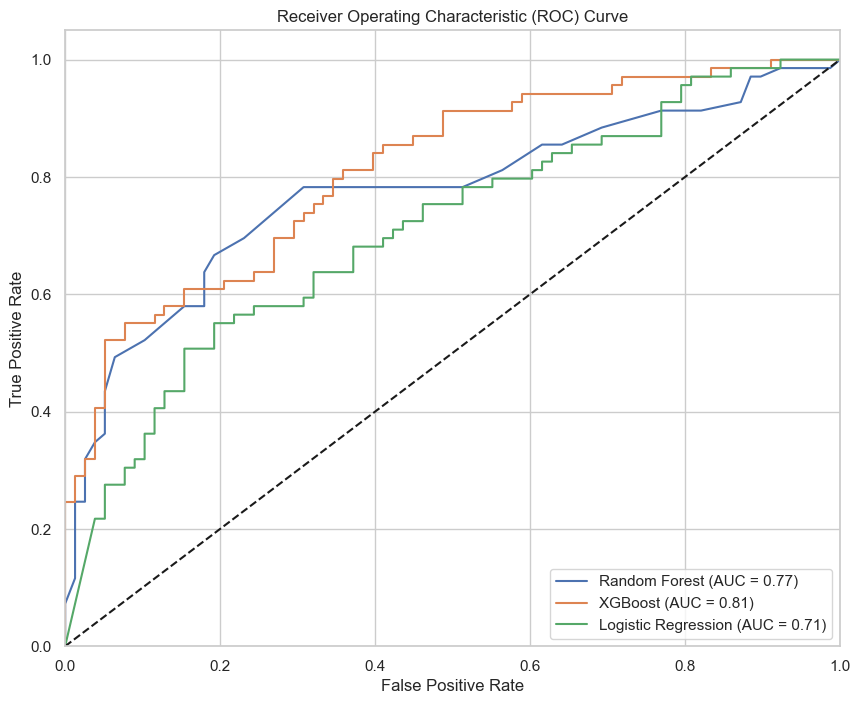

In [89]:
# Calculate ROC curves and AUCs
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_model.predict_proba(x_test)[:,1])
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_model.predict_proba(x_test)[:,1])
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_model.predict_proba(x_test)[:,1])

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {auc(rf_fpr, rf_tpr):.2f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {auc(xgb_fpr, xgb_tpr):.2f})")
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC = {auc(lr_fpr, lr_tpr):.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [90]:
import shap

# For XGBoost
# Initialize the SHAP explainer
explainer_xgb = shap.TreeExplainer(xgb_model)
# Calculate SHAP values
shap_values_xgb = explainer_xgb.shap_values(x_test)

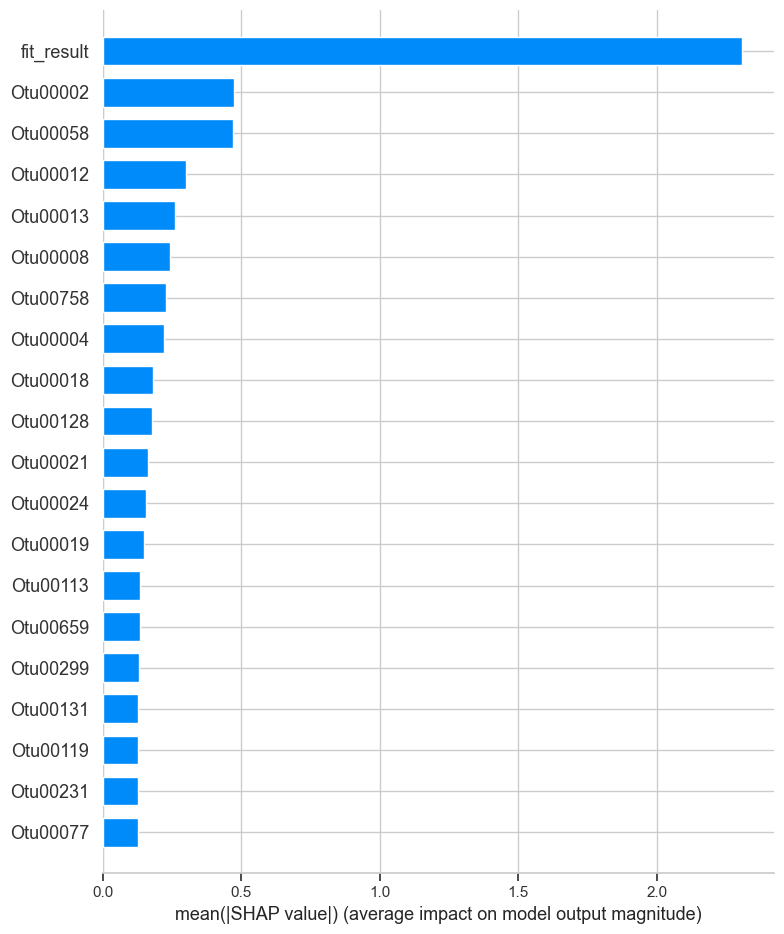

In [91]:
shap.summary_plot(shap_values_xgb, x_test, plot_type="bar", feature_names=x.columns)

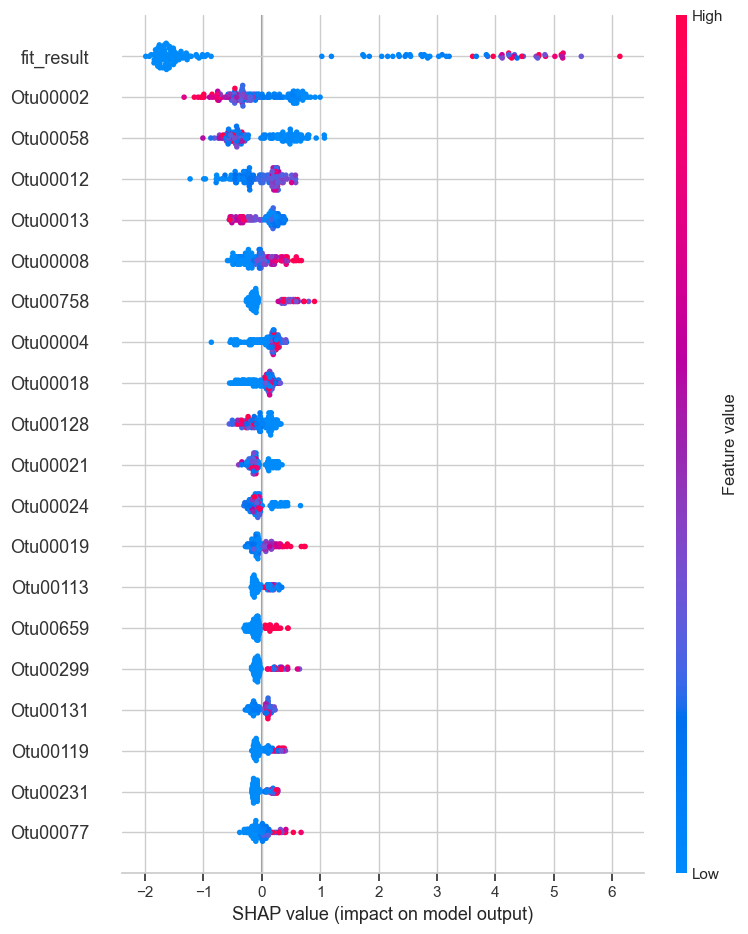

In [16]:
shap.summary_plot(shap_values_xgb, x_test, feature_names=x.columns)

In [20]:
x_test.columns

Index(['fit_result', 'Otu00001', 'Otu00002', 'Otu00003', 'Otu00004',
       'Otu00005', 'Otu00006', 'Otu00007', 'Otu00008', 'Otu00009',
       ...
       'Otu11258', 'Otu11263', 'Otu11269', 'Otu11270', 'Otu11271', 'Otu11274',
       'Otu11277', 'Otu11278', 'Otu11280', 'Otu11281'],
      dtype='object', length=6921)

In [22]:
shap_values_xgb.shape

(147, 6921)

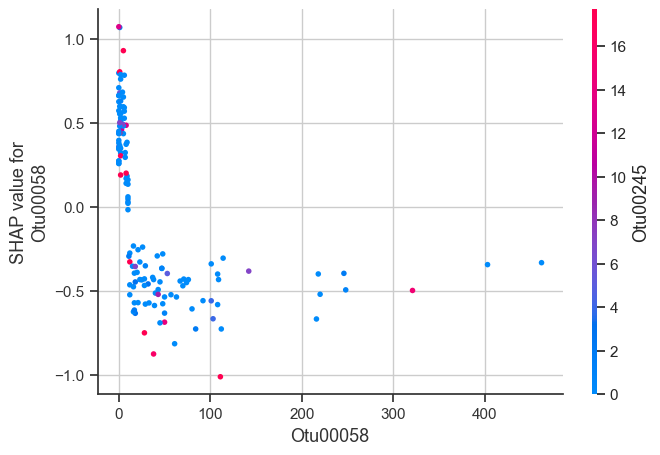

In [25]:
shap.dependence_plot("Otu00058", shap_values_xgb, x_test)

In [34]:
shap.initjs()
explainer5xgb = shap.TreeExplainer(xgb_model)
shap_values5xgb = explainer5xgb.shap_values(x_test)
# shap.initjs()
def local_explainer_xgb(j):
    return(shap.force_plot(explainer_xgb.expected_value, shap_values5xgb[j,:], x_test.iloc[j,:]))
def local_explainer_logit(j):
    return(shap.force_plot(explainer_xgb.expected_value, shap_values5xgb[j,:], x_test.iloc[j,:], link='logit'))

In [33]:
local_explainer_xgb(41)

In [36]:
local_explainer_logit(41)

In [43]:
meta.head()

,sample,fit_result,Site,Dx_Bin,dx,Hx_Prev,Hx_of_Polyps,Age,Gender,Smoke,...,Black,Pacific,Asian,Other,Ethnic,NSAID,Abx,Diabetes_Med,stage,Location
0,2003650,0,U Michigan,High Risk Normal,normal,0.0,1.0,64,m,NaN,...,0,0,0,0,0.0,0.0,0,0,0,NaN
1,2005650,0,U Michigan,High Risk Normal,normal,0.0,1.0,61,m,0.0,...,0,0,0,0,0.0,0.0,0,0,0,NaN
2,2007660,26,U Michigan,High Risk Normal,normal,0.0,1.0,47,f,0.0,...,0,0,0,0,0.0,0.0,0,0,0,NaN
3,2009650,10,Toronto,Adenoma,adenoma,0.0,1.0,81,f,1.0,...,0,0,0,0,0.0,1.0,0,0,0,NaN
4,2013660,0,U Michigan,Normal,normal,0.0,0.0,44,f,0.0,...,0,0,0,0,0.0,1.0,0,0,0,NaN


In [52]:
from preprocess1 import process_SRNdata
shared = pd.read_table("../data/baxter.0.03.subsample.shared")
meta = pd.read_table("../data/metadata.tsv")

# Define x (features) and y (labels)
x11, y11, data11 = process_SRNdata(shared, meta)

/Users/kayadetunji/Documents/mBio_study_improv/codes/preprocess1.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data['Dx_Bin'].replace(diagnosis)


ValueError: not enough values to unpack (expected 3, got 2)

In [85]:
meta['Diabetic'] = meta['Diabetic'].replace({np.nan: 1.0})

In [86]:
meta.Diabetic.value_counts(dropna=False)

Diabetic
0.0    432
1.0     58
Name: count, dtype: int64

In [58]:
meta.s

490